In [54]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import random

In [55]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

In [56]:
def plotter(day, dat):
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in dat['HR'][day].split(',')], dtype=float)) \
        if not isinstance(dat['HR'][day], np.ndarray) else len(dat['HR'][day]) # entry could be ndarray or string

    for i, variable in enumerate(VARIABLES):
        entry = dat[variable][day]
        time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
            if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def na_visualizer(days, dat):
    for day in days:
        entry = np.array([value if value != 'None' else None for value in dat['ActivityCounts'][day].split(',')], dtype=float) \
            if not isinstance(dat['ActivityCounts'][day], np.ndarray) else dat['ActivityCounts'][day] # entry could be ndarray or string
        na_matrix = np.zeros((len(VARIABLES), entry.shape[0]))

        for i, variable in enumerate(VARIABLES):
            entry = dat[variable][day]
            time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
                if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

            na_data = np.where(np.isnan(time_series), 0.0, 1.0)
            na_matrix[i, :] = na_data

        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            entry = dat[variable][day]
            time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
                if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

# Import data

In [57]:
# file path to data folder
path = './Output'

In [58]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

Visualization: plot random day of dataset (<span style="color:red">fatigued</span>, <span style="color:green">vigilant</span>)

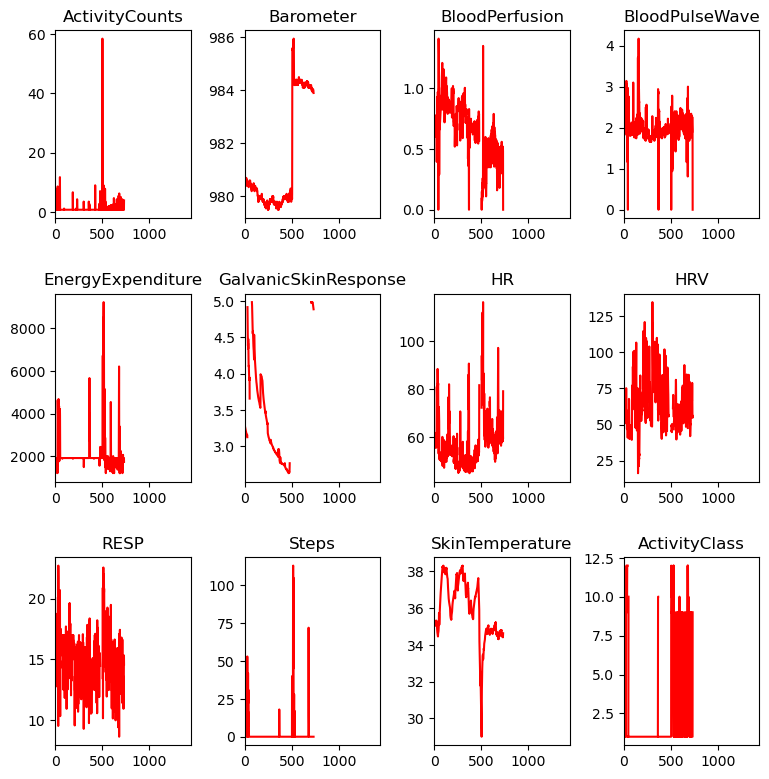

In [59]:
day = random.sample(range(data.shape[0]), 1)[0]
plotter(day, data)

# Imputation

## a) Visualization

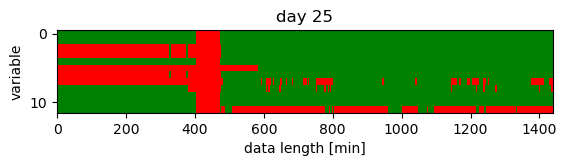

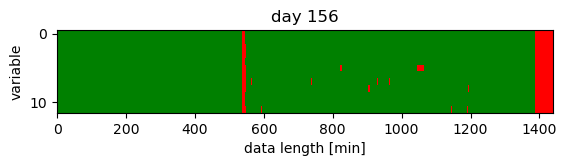

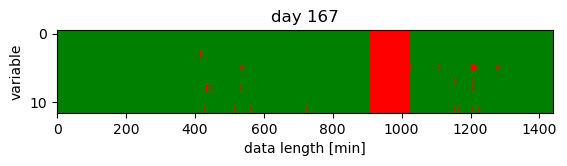

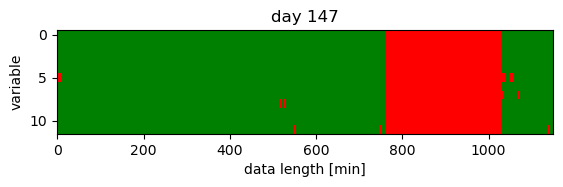

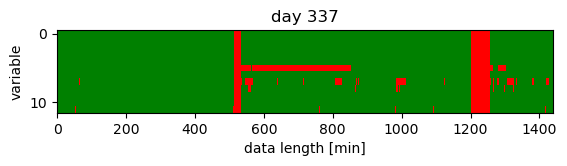

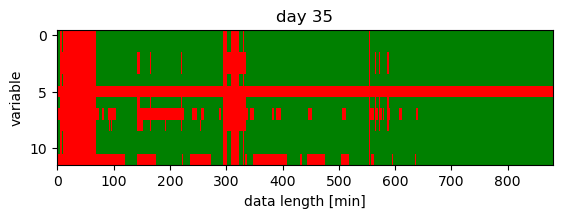

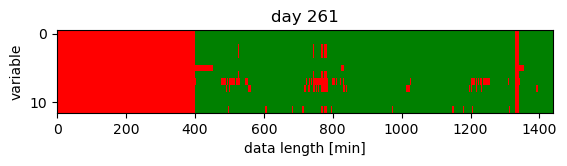

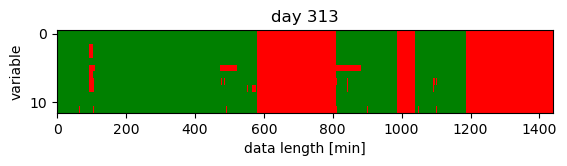

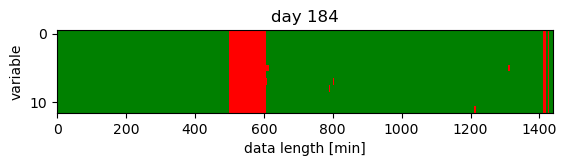

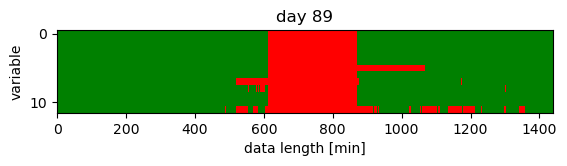

In [60]:
# visualize missing data
N = 10
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

## b) Small sequence imputation

,sequence_length,occurrences
0,1,10442
1,2,4282
2,3,1974
3,4,1273
4,5,891
...,...,...
559,1165,1
560,1175,1
561,1270,11
562,1354,12


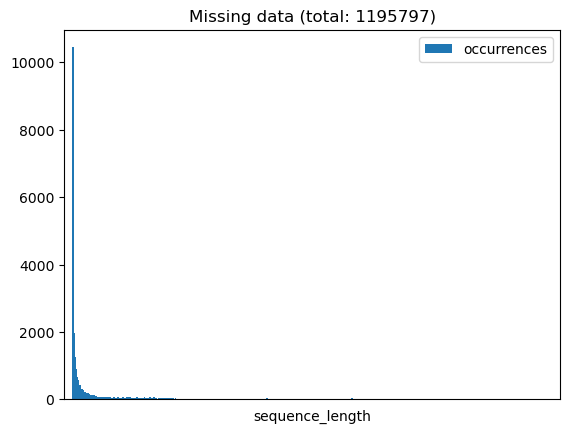

In [61]:
# before imputation
na_sequence_lengths(data)

In [62]:
# small sequence imputation
n_days, n_cols = data.shape
variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

for day in range(n_days):
    for variable in variables:
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        for i, datapoint in enumerate(time_series):
            if np.isnan(datapoint): # datapoint is NA
                try:
                    # single missing datapoint
                    # (in between data)
                    if not np.isnan(time_series[i-1]) and not np.isnan(time_series[i+1]):
                        time_series[i] = time_series[i-1] # forward copy
                    # (at start of data)
                    elif i == 0 and not np.isnan(time_series[i+1]):
                        time_series[i] = time_series[i+1] # backward copy
                    # (at end of data)
                    elif i == len(time_series) - 1 and not np.isnan(time_series[i-1]):
                        time_series[i] = time_series[i-1] # forward copy

                    # 2 missing datapoints
                    # (in between data)
                    elif not np.isnan(time_series[i-1]) and np.isnan(time_series[i+1]) and not np.isnan(time_series[i+2]):
                        time_series[i] = time_series[i-1] # forward copy
                        time_series[i+1] = time_series[i+2] # backward copy
                    # (at start of data)
                    elif i == 0 and np.isnan(time_series[i+1]) and not np.isnan(time_series[i+2]):
                        time_series[i] = time_series[i+2] # backward copy
                        time_series[i+1] = time_series[i+2] # backward copy
                    # (at end of data)
                    elif i == len(time_series) - 2 and np.isnan(time_series[i+1]) and not np.isnan(time_series[i-1]):
                        time_series[i] = time_series[i-1] # backward copy
                        time_series[i+1] = time_series[i-1] # backward copy

                    else:
                        pass
                except IndexError:
                    pass

        data[variable][day] = time_series

C:\Users\jjung\AppData\Local\Temp\ipykernel_32672\1193497320.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable][day] = time_series


,sequence_length,occurrences
0,3,1974
1,4,1273
2,5,891
3,6,675
4,7,563
...,...,...
557,1165,1
558,1175,1
559,1270,11
560,1354,12


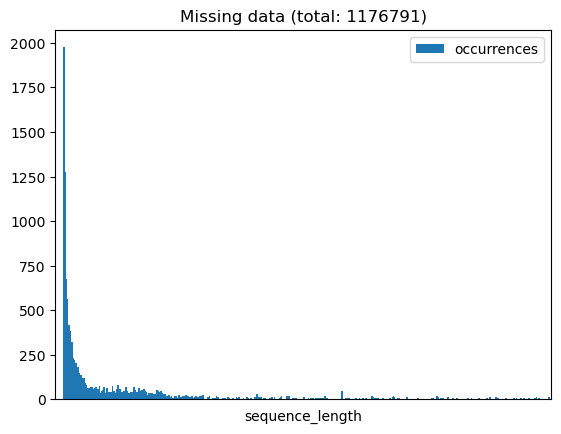

In [63]:
# after imputation
na_sequence_lengths(data)

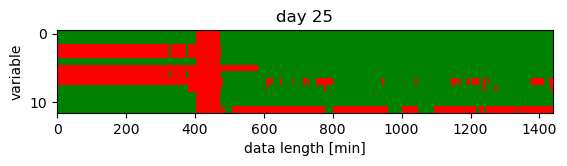

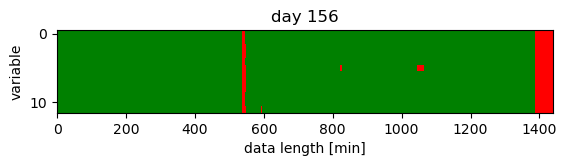

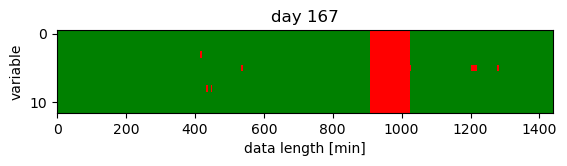

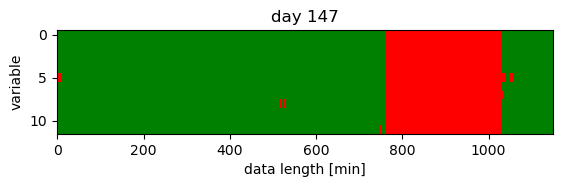

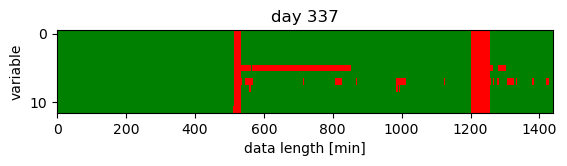

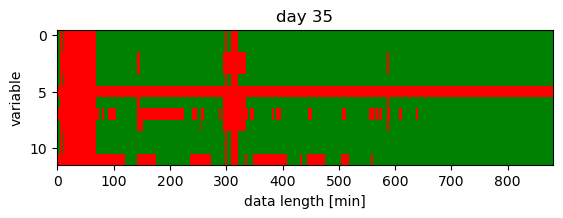

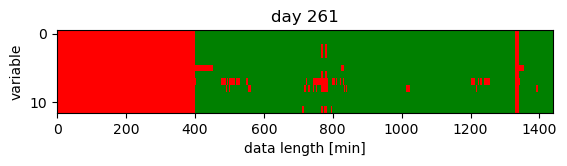

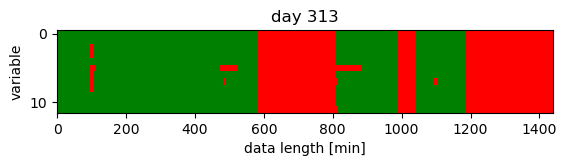

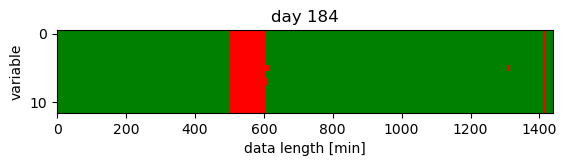

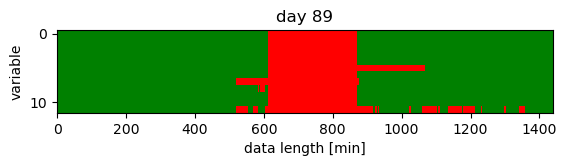

In [64]:
na_visualizer(days, data)

# Segmentation

In [65]:
SEQUENCE_LENGTH = None

# Filter data

# Spectrogram conversion

# Feature vector

ReIP and timezone into feature vector